In [2]:
import numpy as np
import cv2
from numpy.fft import fft, fftshift, fft2, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

Y = fftshift(X) rearranges a Fourier transform X by shifting the zero-frequency component to the center of the array.

- If X is a vector, then fftshift swaps the left and right halves of X.

- If X is a matrix, then fftshift swaps the first quadrant of X with the third, and the second quadrant with the fourth.

- If X is a multidimensional array, then fftshift swaps half-spaces of X along each dimension.

# QUESTION 1

## Part 1

In [3]:
# Implement FFT (Recursive) 
def fft(x):
    N = len(x)
    if N <= 1: return x
    even = fft(x[0::2])
    odd =  fft(x[1::2])
    T = [np.exp(-2j*np.pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

In [4]:
fft([1.0,1.0,1.0, 0.0])

[(3+0j), (6.123233995736766e-17-1j), (1+0j), (-6.123233995736766e-17+1j)]

In [5]:
np.fft.fft([1.0,1.0,1.0, 0.0])

array([3.+0.j, 0.-1.j, 1.+0.j, 0.+1.j])

## Part 2
Implement 2D FFT from 1D FFT
- do 1D FFT on each row (real to complex)
- do 1D FFT on each column resulting from (1) (complex to complex)


In [182]:
def fft2d(x):
    return np.asarray([fft(row) for row in np.asarray([fft(row) for row in x]).T]).T

In [183]:
x = np.asarray([[1,2,3,4], [5,6,7,8], [9,10,11,12], [12,13,14,15]])

In [184]:
fft2d(x)

array([[132. +0.j,  -8. +8.j,  -8. +0.j,  -8. -8.j],
       [-32.+28.j,   0. +0.j,   0. +0.j,   0. +0.j],
       [-28. +0.j,   0. +0.j,   0. +0.j,   0. +0.j],
       [-32.-28.j,   0. +0.j,   0. +0.j,   0. +0.j]])

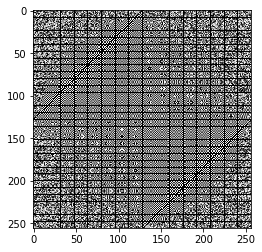

In [405]:
image = cv2.cvtColor(cv2.imread("./input_data/rectangle.jpg"), cv2.COLOR_BGR2GRAY)
plt.imshow(np.real(fft2d(image)).astype("uint8"), cmap = 'gray')

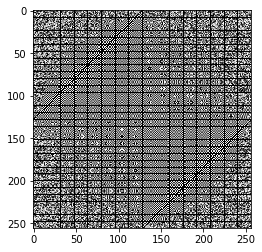

In [400]:
plt.imshow(np.real(fft2(image)).astype("uint8"), cmap = 'gray')

# Question 2

## Ideal Filter

In [187]:
def ideal_filter(image, d0):
    image = cv2.imread(image, 0)
    M, N = image.shape
    H = np.zeros_like(image)
    for u in range(M):
        for v in range(N):
            if np.sqrt(np.power((u - M/2), 2) + np.power((v - N/2), 2)) <= d0:
                H[u][v] = 1
            else:
                H[u][v] = 0
    
    fft_image = fftshift(fft2(image))
    result = ifft2(ifftshift(np.multiply(H, fft_image)))
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.axis("off")
    ax1.imshow(np.real(abs(image)),cmap = 'gray')
    ax2.axis("off")
    ax2.imshow(np.real(result),cmap = "gray")

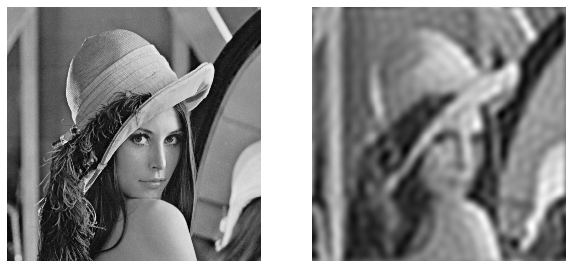

In [188]:
image = "./input_data/lena.jpg"
ideal_filter(image, 20)

## Butterworth Filter

In [189]:
def butterworth(image, d0, n = 2):
    image = cv2.imread(image, 0)
    M, N = image.shape
    H = (np.zeros_like(image)).astype("float")
    for u in range(M):
        for v in range(N):
            H[u,v] = 1 + np.power(((np.power((u - M/2), 2) + np.power((v - N/2), 2)) / d0**2), n)
            H[u,v] = 1/H[u,v]
    fft_image = fftshift(fft2(image))
    result = ifft2(ifftshift(np.multiply(H, fft_image)))
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.axis("off")
    ax1.imshow(np.real(abs(image)),cmap = 'gray')
    ax2.axis("off")
    ax2.imshow(np.real(result),cmap = "gray")

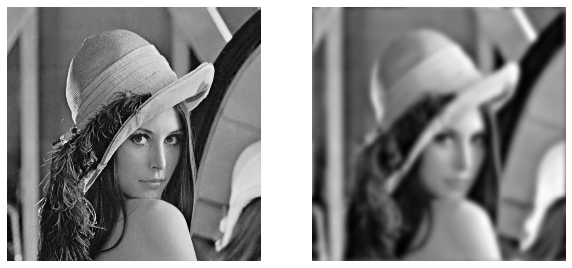

In [190]:
image = "./input_data/lena.jpg"
butterworth(image, 20)

## Gaussian filter

In [191]:
def gaussian(image, d0):
    image = cv2.imread(image, 0)
    M, N = image.shape
    H = (np.zeros_like(image)).astype("float")
    for u in range(M):
        for v in range(N):
            H[u,v] = np.power((u - M/2), 2) + np.power((v - N/2), 2)
            H[u,v] = np.exp((-1 * H[u,v]) / (2*(d0**2)))
    fft_image = fftshift(fft2(image))
    result = ifft2(ifftshift(np.multiply(H, fft_image)))
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.axis("off")
    ax1.imshow(np.real(abs(image)),cmap = 'gray')
    ax2.axis("off")
    ax2.imshow(np.real(result),cmap = "gray")
    return np.real(result)

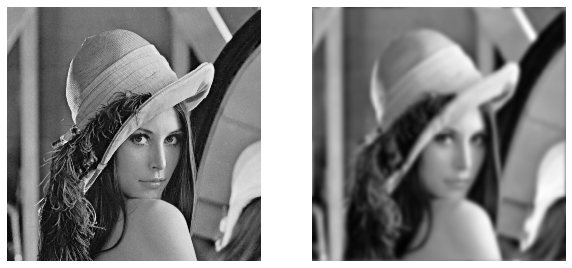

In [192]:
image = "./input_data/lena.jpg"
result1 = gaussian(image, 20)

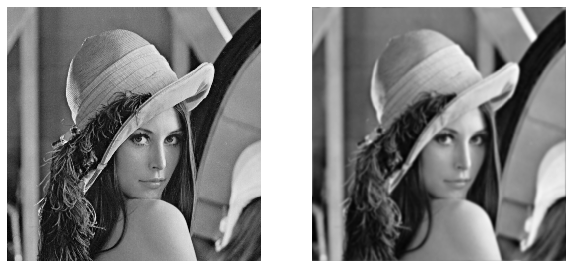

In [193]:
result2 = gaussian(image, 40)

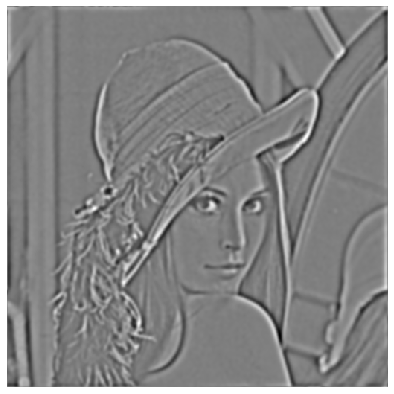

In [195]:
fig = plt.figure(figsize=(7,7))
plt.axis("off")
plt.imshow(result2-result1, cmap = "gray")

### Justification:
The difference between the two Gaussian low pass filters results in a band pass filter with limits between the frequencies allowed by the two low pass filters.

# Question 3

![title](3.jpg)

# Question 4
Apply filter mask in FFT of noisy image to get rid of frequencies which contribute to noise while preserving important frequencies which are equivalent to the image. IFFT of the resultant masked image shows a now denoised image.

In [266]:
noised = cv2.imread("input_data/land.png", 0)
noised.shape

(196, 260)

array([[143.29511232, 141.31768529, 140.24012655, ..., 143.6035849 ,
        144.82130962, 144.76215675],
       [136.3862782 , 134.45944005, 133.25339195, ..., 136.16516713,
        137.54410535, 137.66999967],
       [131.34265441, 129.6198039 , 128.57406581, ..., 131.04569601,
        132.36358126, 132.49457941],
       ...,
       [149.86070296, 146.70749886, 145.65354111, ..., 155.49839055,
        155.3075156 , 153.29483275],
       [150.87853005, 148.49604554, 147.69139481, ..., 154.07018547,
        154.47052528, 153.32819397],
       [149.12462569, 147.08783417, 146.23077327, ..., 150.513797  ,
        151.40222355, 150.93212431]])

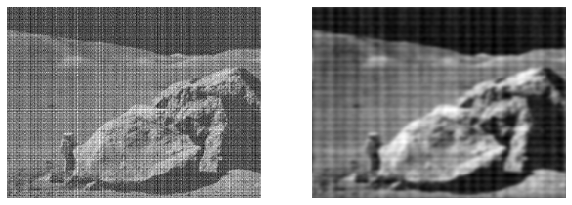

In [267]:
gaussian("input_data/land.png", 22)

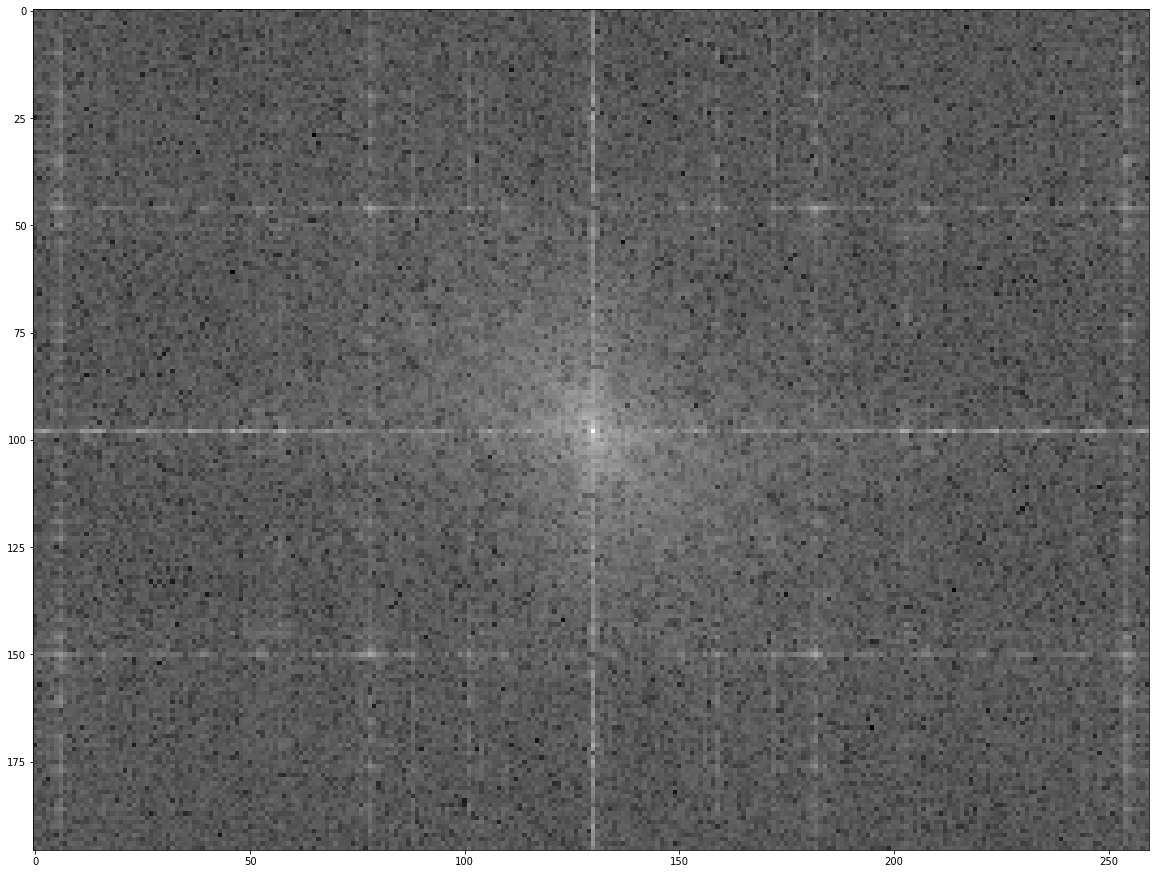

In [440]:
fft_noised = (fftshift(fft2(noised)))
fig = plt.figure(figsize=(20,20))
plt.imshow(np.log(abs((fft_noised))), cmap = "gray")

/home/deepti/anaconda3/envs/pleasework/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


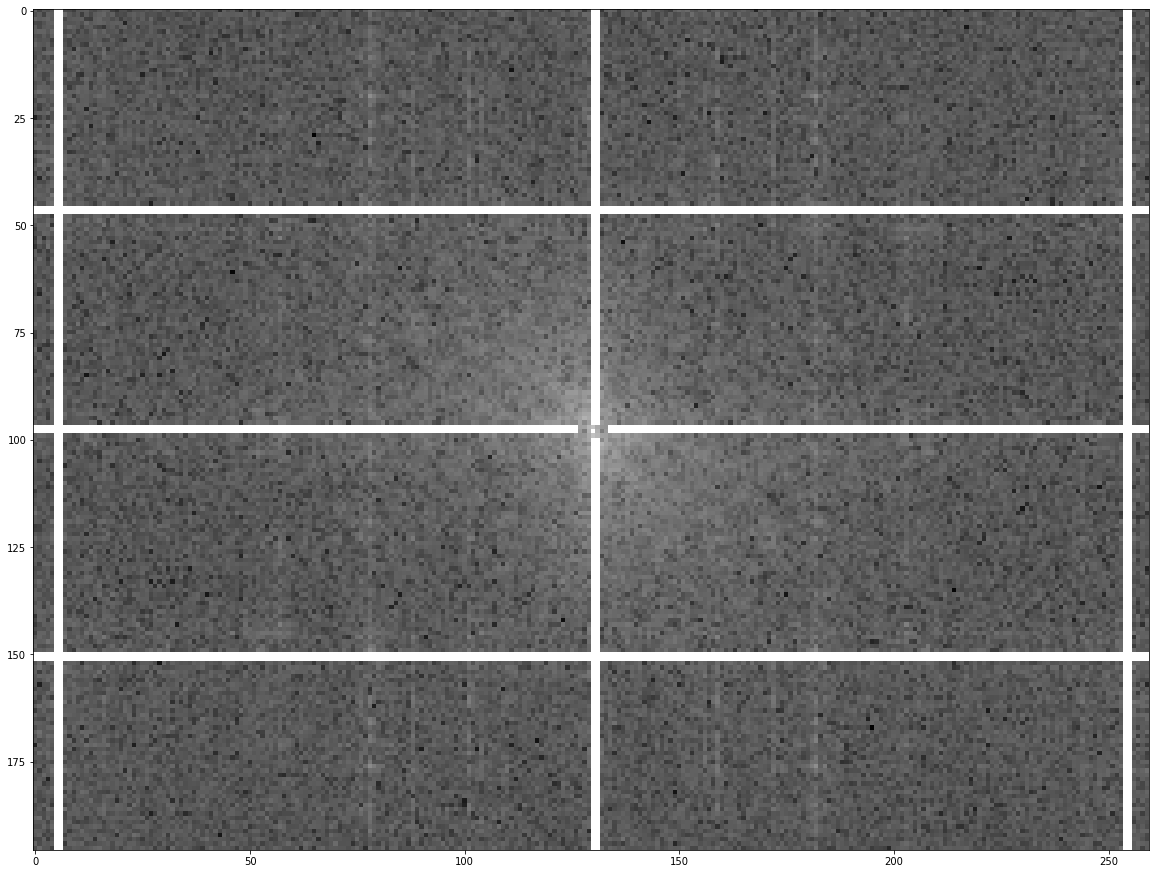

In [441]:
for j in range(46,48):
    for n in range(0,260):
        fft_noised[j,n] = 0

for j in range(150,152):
    for n in range(0,260):
        fft_noised[j,n] = 0

for j in range(97, 99):
    for n in range(0, 127):
        fft_noised[j,n] = 0
    for n in range(134, 260):
        fft_noised[j,n] = 0

for j in range(0,196):
    for n in range(5, 7):
        fft_noised[j,n] = 0
    for n in range(254,256):
        fft_noised[j,n] = 0
    
for n in range(130, 132):
    for j in range(0, 97):
        fft_noised[j,n] = 0
    for j in range(100, 196):
        fft_noised[j,n] = 0
        
fig = plt.figure(figsize=(20,20))
plt.imshow(np.log(abs((fft_noised))), cmap = "gray")

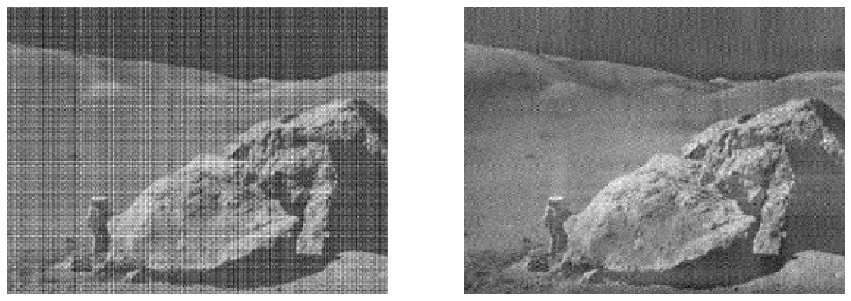

In [443]:
denoised = ifft2(ifftshift(fft_noised))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.axis("off")
ax1.imshow(np.real(abs(noised)),cmap = 'gray')
ax2.axis("off")
ax2.imshow(np.real(abs(denoised)),cmap = "gray")

# Question 5

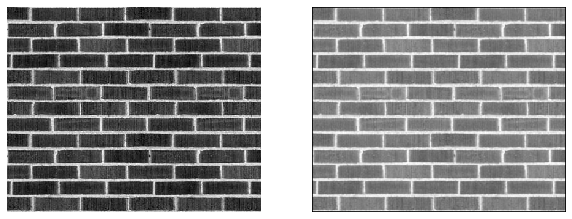

In [445]:
filter1 = np.asarray([[0,1,0],[1,2,1],[0,1,0]])
image = cv2.imread("./input_data/bricks.jpg", 0)

convolved = convolve2d(image, filter1)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.axis("off")
ax1.imshow(image,cmap = 'gray')
ax2.axis("off")
ax2.imshow(convolved,cmap = "gray")

In [446]:
ffted = fftshift(fft2(filter1, s=(shape1, shape2)))
ffted

array([[-2.        +0.00000000e+00j, -1.99881406+4.86876068e-02j,
        -1.99525903+9.72597319e-02j, ..., -1.98934337-1.45601168e-01j,
        -1.99525903-9.72597319e-02j, -1.99881406-4.86876068e-02j],
       [-1.99881406+4.86876068e-02j, -1.9964434 +9.73174642e-02j,
        -1.99170753+1.45774202e-01j, ..., -1.99170665-9.70865694e-02j,
        -1.99644287-4.86298488e-02j, -1.99881388+5.55111512e-17j],
       [-1.99525903+9.72597319e-02j, -1.99170753+1.45774202e-01j,
        -1.98579678+1.94058085e-01j, ..., -1.9917019 -4.85143672e-02j,
        -1.99525622+5.55111512e-17j, -1.99644287+4.86298488e-02j],
       ...,
       [-1.98934337-1.45601168e-01j, -1.99170665-9.70865694e-02j,
        -1.9917019 -4.85143672e-02j, ..., -1.96812959-2.89648645e-01j,
        -1.97754082-2.41996755e-01j, -1.98461768-1.93942860e-01j],
       [-1.99525903-9.72597319e-02j, -1.99644287-4.86298488e-02j,
        -1.99525622+8.32667268e-17j, ..., -1.97754082-2.41996755e-01j,
        -1.98579678-1.94058085e-01j

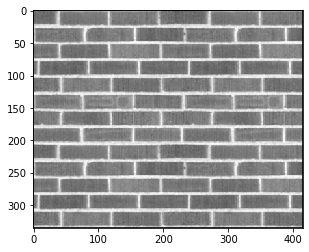

In [447]:
shape1 = filter1.shape[0] + image.shape[0] - 1
shape2 = filter1.shape[1] + image.shape[1] - 1

ffted = fftshift(fft2(filter1, s=(shape1, shape2)))
fft_img = fftshift(fft2(image, s=(shape1, shape2)))

result = ifft2(ifftshift(np.multiply(fft_img,ffted)))
result = abs(result)

plt.imshow(result, cmap="gray")

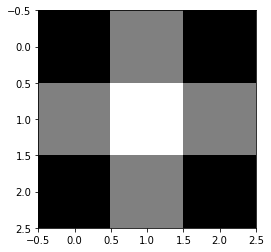

In [454]:
abc = fftshift(fft2(filter1))
plt.imshow(abs(abc), cmap = "gray")

This is essentially the graph of a low pass filter ie, goes from high values (the white part) to low (the gray part). Thus, it is proved that this is a low pass filter in frequency domain.

# Question 6

### Convolution

In [407]:
import time
img1 = cv2.imread("./input_data/lena.jpg", 0)  # Shape = 512,512
img2 = cv2.imread("./input_data/gradient.png", 0) # Shape = 225,225

start_time = time.process_time()
conv = convolve2d(img1, img2.astype(float))

time_conv = time.process_time() - start_time

print(time_conv)

176.05774433499994


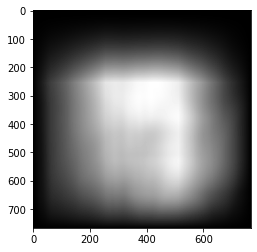

In [408]:
plt.imshow(conv, cmap="gray")

### FFT

0.3328123709999318


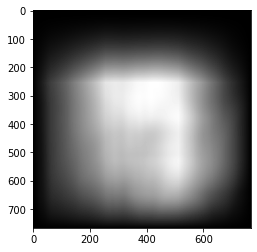

In [409]:
shape1 = img1.shape[0] + img2.shape[0] - 1
shape2 = img1.shape[1] + img2.shape[1] - 1

start_time = time.process_time()

res = ifft2(ifftshift(fftshift(fft2(img1, s=(shape1, shape2))) * fftshift(fft2(img2, s=(shape1, shape2)))))
res = abs(res)

time_fft = time.process_time() - start_time
print(time_fft)
plt.imshow(res, cmap="gray")

## Part 2


In [ ]:
img2 = cv2.imread("./input_data/lena.jpg", 0)
img1 = cv2.imread("./input_data/gradient.png", 0)

start_time = time.process_time()
conv = convolve2d(img1, img2.astype(float))

time_conv = time.process_time() - start_time

print(time_conv)
plt.imshow(conv, cmap="gray")

In [ ]:
shape1 = img1.shape[0] + img2.shape[0] - 1
shape2 = img1.shape[1] + img2.shape[1] - 1

start_time = time.process_time()

res = ifft2(ifftshift(fftshift(fft2(img1, s=(shape1, shape2))) * fftshift(fft2(img2, s=(shape1, shape2)))))
res = abs(res)

time_fft = time.process_time() - start_time
print(time_fft)
plt.imshow(res, cmap="gray")

#### Observations: 
- 2D Convolution takes much more time than performing convolution using FFT, as FFT is highly optimised. 

- The difference is evident when Image 2 size is larger. This assymetry appears as the 2nd image acts as the filter or the window on the 1st image.

# Question 7

## Aliasing : 
- Aliasing is an effect that causes different signals to become indistinguishable (or aliases of one another) when sampled.
- Aliasing is generally avoided by applying low pass filters or anti-aliasing filters to the input signal before sampling.

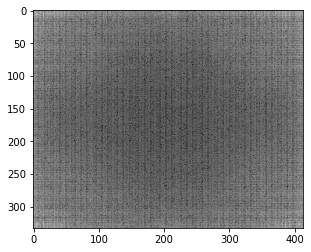

In [352]:
brick = cv2.imread("input_data/bricks.jpg", 0)
og_ffted = fft2(brick)

plt.imshow(np.log(abs(og_ffted)), cmap="gray")

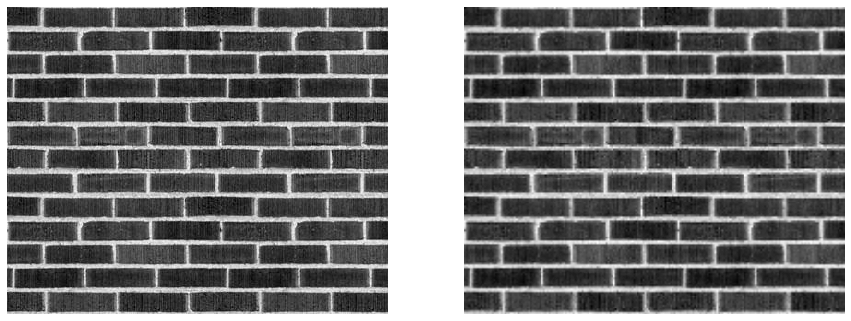

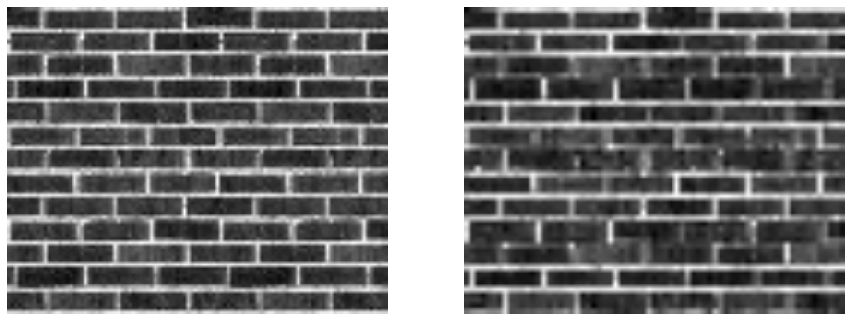

In [392]:
down_sampled=brick[0::4,0::4]

down_sampled = cv2.resize(down_sampled, (413,333))


fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.axis("off")
ax1.imshow(brick,cmap = 'gray')
ax2.axis("off")
ax2.imshow(cv2.resize(brick[0::2,0::2], (413,333)),cmap = "gray")

fig,(ax3, ax4) = plt.subplots(1, 2, figsize=(15,15))
ax3.axis("off")
ax3.imshow(cv2.resize(brick[0::4,0::4], (413,333)),cmap = "gray")
ax4.axis("off")
ax4.imshow(cv2.resize(brick[0::6,0::6], (413,333)),cmap = "gray")

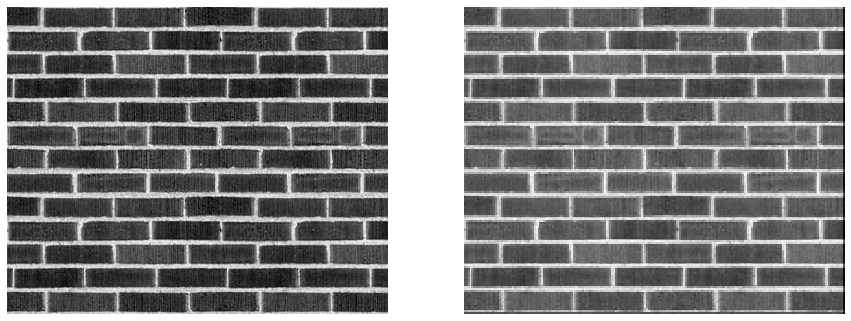

In [380]:
from skimage.measure import block_reduce
brick_red1 = block_reduce(brick,(2,2))
brick_red2 = block_reduce(brick,(4,4))
brick_red3 = block_reduce(brick,(6,6))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.axis("off")
ax1.imshow(brick,cmap = 'gray')
ax2.axis("off")
ax2.imshow(brick_red1,cmap = "gray")

# fig,(ax3, ax4) = plt.subplots(1, 2, figsize=(15,15))
# ax3.axis("off")
# ax3.imshow(brick_red2,cmap = "gray")
# ax4.axis("off")
# ax4.imshow(brick_red3,cmap = "gray")

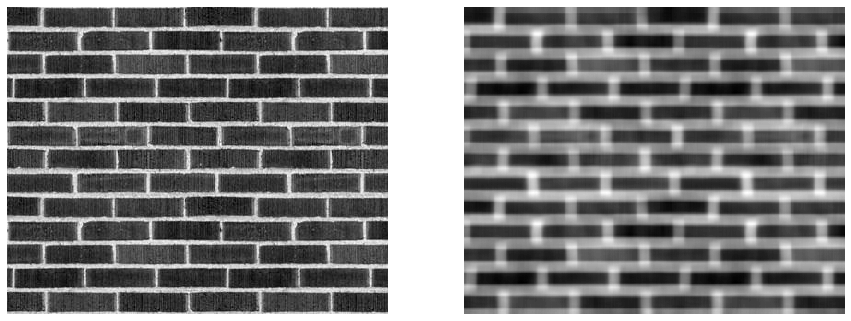

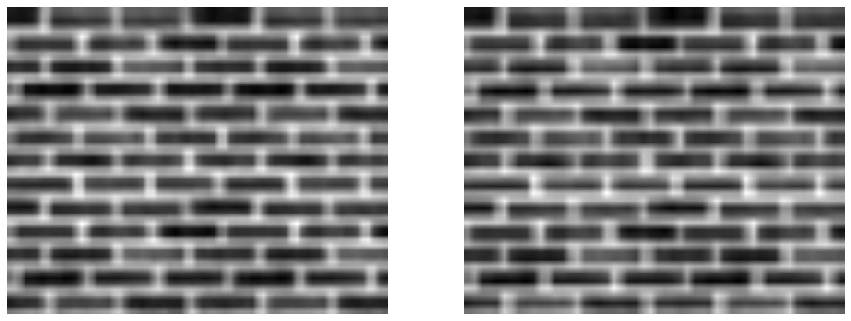

In [398]:
blurred = cv2.blur(brick, (12,12))
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.axis("off")
ax1.imshow(brick,cmap = 'gray')
ax2.axis("off")
ax2.imshow(blurred,cmap = "gray")

fig,(ax3, ax4) = plt.subplots(1, 2, figsize=(15,15))
ax3.axis("off")
ax3.imshow(cv2.resize(blurred[0::6,0::6], (413,333)),cmap = "gray")
ax4.axis("off")
ax4.imshow(cv2.resize(blurred[0::8,0::8], (413,333)),cmap = "gray")

### Observations:

Nyquist Rate obtained = 4, 4 when image is not blurred.

But when image is blurred, Nyquist rate can be observed to increase quite a lot.


# Question 8

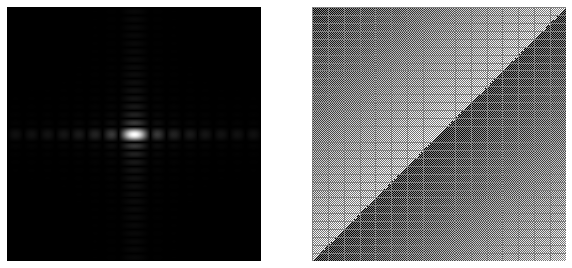

In [201]:
image = cv2.cvtColor(cv2.imread("./input_data/rectangle.jpg"), cv2.COLOR_BGR2GRAY)
ffted = fftshift(fft2(image))


fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.axis("off")
ax1.imshow((abs(ffted)),cmap = 'gray')
ax2.axis("off")
ax2.imshow(np.angle(ffted),cmap = "gray")

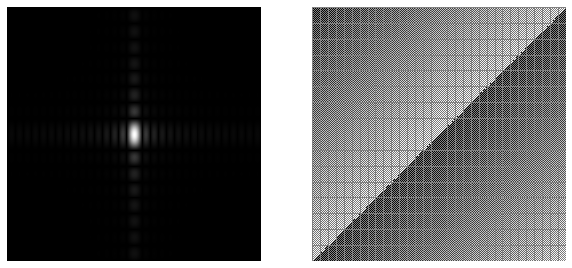

In [202]:
rotated = np.rot90(image)
fft_rotated = fftshift(fft2(rotated))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.axis("off")
ax1.imshow((abs(fft_rotated)),cmap = 'gray')
ax2.axis("off")
ax2.imshow(np.angle(fft_rotated),cmap = "gray")

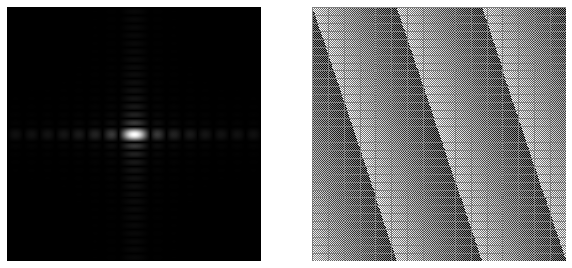

In [203]:
trans = np.roll(image, 2)
fft_trans = fftshift(fft2(trans))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.axis("off")
ax1.imshow((abs(fft_trans)),cmap = 'gray')
ax2.axis("off")
ax2.imshow(np.angle(fft_trans),cmap = "gray")

### Justification:

![title](./8A.jpg)

![title](./8B.jpg)